In [325]:
#!sudo apt-get update --fix-missing
#!sudo apt install graphviz -y
#!pip install pydot

In [4]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter #https://docs.scipy.org/doc/scipy-0.10.0/reference/generated/scipy.signal.lfilter.html
from scipy import signal
import matplotlib.pyplot as plt

2024-02-12 01:02:36.180884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(924,)
(924,)
(1, 1024, 1)
(1, 1024, 1)


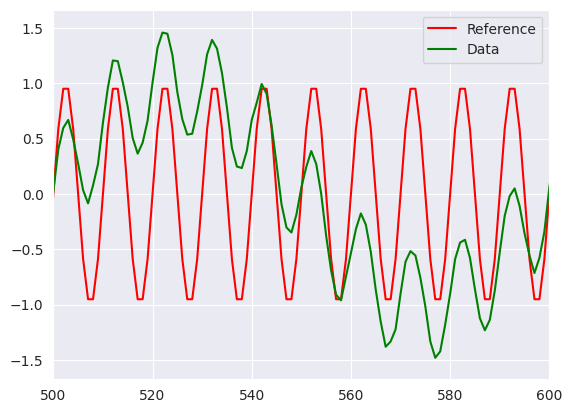

In [94]:
#Generate Data
f = 1
f2=0.1
Fs = f*10
N = 1024
noise  = np.random.normal(0,scale=0.02,size=N)
cW =2*np.cos(2*np.pi*f/Fs)
b=[1]
a=[5, -8.090, 5] #[5, 5*-cW ,5]

reference = np.sin(2 * np.pi * f * np.arange(N) / Fs)
data = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs) + noise +  np.sin(2 * np.pi * f2 * np.arange(N) / Fs)

#kernel_initializer=tf.keras.initializers.Constant(value=[5, -8.090, 5])
#resonator = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='resonator',kernel_initializer=kernel_initializer)
#data=resonator(tf.reshape(noise, (1, len(noise), 1)))
#plt.figure()
#freq, Pxx_den = signal.welch(np.squeeze(data), Fs, nperseg=1024)
#plt.semilogy(freq, Pxx_den,label='Estimated Resonator Data Spectrum')
#w, h = signal.freqz(1,a=a,fs=Fs)
#plt.semilogy(w, abs(h), 'r',label='True Resonator Spectrum')
#plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
#plt.legend()
#plt.show()

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(reference,label='Reference',c='r')
plt.plot(data,label='Data',c='g')
plt.legend()
plt.xlim([500,600])



S=N#-100 #3000
B=1#int(N/S)
print(reference[0:-100].shape)
print(reference[100:].shape)
x_train=np.reshape(reference,(B,S,1))
y_train=np.reshape(data,(B,S,1))
print(x_train.shape)
print(y_train.shape)

[-0.51573     0.74043894  0.06031699]
[5, -8.09, 5]


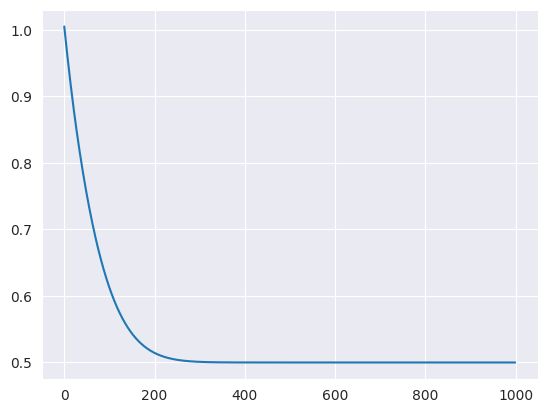

In [97]:
input = tf.keras.Input(shape=(S,1),name='data')
kernel_initializer=None #tf.keras.initializers.Constant(value=[5, -8.090, 5])
conv = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='Conv1',
                              kernel_initializer=kernel_initializer)(input)
#residue= tf.keras.layers.Subtract(name='Subtract')([input, conv])
model = tf.keras.Model(inputs=input,outputs=conv)
tf.keras.utils.plot_model(model, show_shapes=True)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3), loss=tf.keras.losses.MeanSquaredError())
history=model.fit(x_train, y_train,epochs=1000,shuffle=True,verbose=0)
plt.plot(history.history['loss'])
a_hat=np.squeeze(model.layers[1].get_weights()[0])
print(a_hat)
print(a)


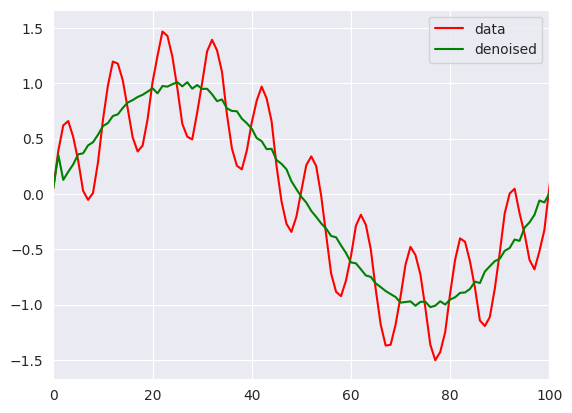

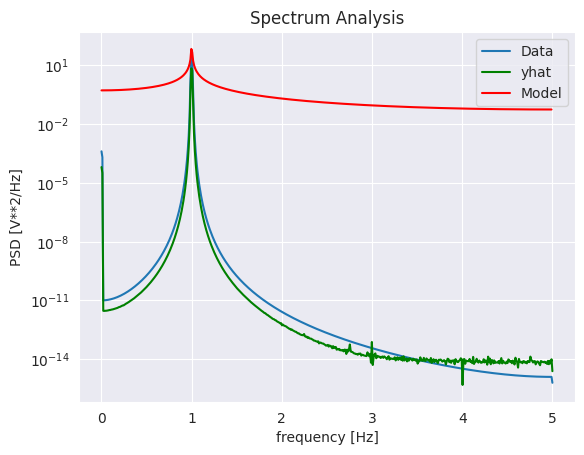

In [98]:
yhat=np.squeeze(model(x_train)) #predict(batched,verbose=0)
denoised=data-yhat
plt.plot(data,label='data',c='r')
plt.plot(denoised,label='denoised',c='g')
plt.legend()
plt.xlim([0,100])


plt.figure()
freq, Pxx_den = signal.welch(reference, Fs, nperseg=1024)
plt.semilogy(freq, Pxx_den,label='Data')

freq, Pxx_den = signal.welch(yhat, Fs, nperseg=1024)
plt.semilogy(freq, Pxx_den,label='yhat',c='g')


w, h = signal.freqz(b,a=a,fs=Fs)
plt.semilogy(w, abs(h), 'r',label='Model')

plt.title('Spectrum Analysis')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

# Adaptive Noise Canceler

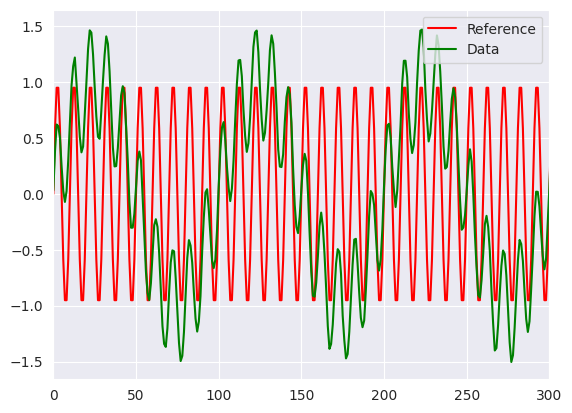

In [128]:
#Generate Data
f = 1
f2=0.1
Fs = f*10
N = 1024
noise  = np.random.normal(0,scale=0.02,size=N)
reference = np.sin(2 * np.pi * f * np.arange(N) / Fs)
data = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs) + noise +  np.sin(2 * np.pi * f2 * np.arange(N) / Fs)

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(reference,label='Reference',c='r')
plt.plot(data,label='Data',c='g')
plt.legend()
plt.xlim([0,300])

S=N
B=1
x_train=np.reshape(reference,(B,S,1))
y_train=np.reshape(data,(B,S,1))

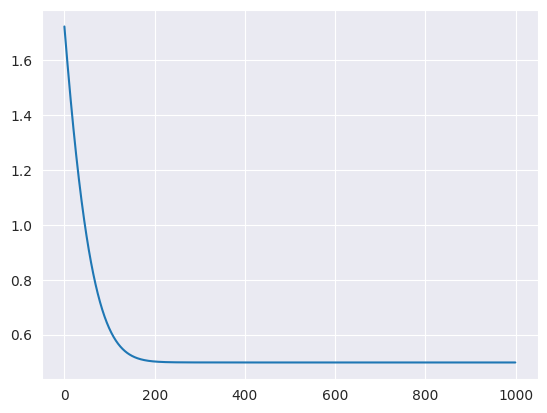

In [138]:
#Train
ref = tf.keras.Input(shape=(S,1),name='ref')
rec = tf.keras.Input(shape=(S,1),name='rec')
conv = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='Conv1')(ref)
denoised = tf.keras.layers.Subtract()([rec,conv])
model = tf.keras.Model(inputs=[ref,rec],outputs=[conv,denoised])
loss={'Conv1': tf.keras.losses.MeanSquaredError()}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-3), loss=loss)
tf.keras.utils.plot_model(model, show_shapes=False)
inputs={'ref':x_train,'rec':y_train}
history=model.fit(inputs, y_train,epochs=1000,shuffle=True,verbose=0)
plt.plot(history.history['loss'])

(0.0, 100.0)

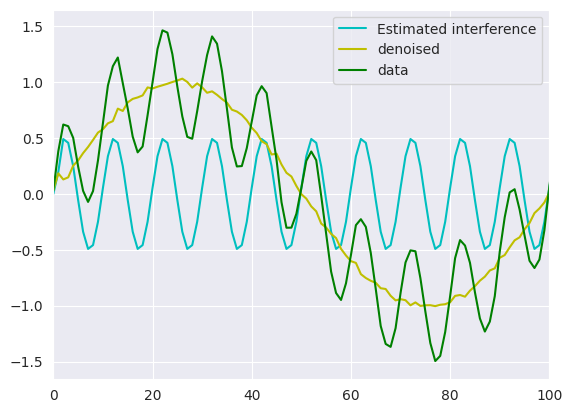

In [135]:
#Denoise and check results
out=model(inputs)
plt.plot(np.squeeze(out[0]),label='Estimated interference',c='c')
plt.plot(np.squeeze(out[1]),label='denoised',c='y')
plt.plot(data,label='data',c='g')
plt.legend()
plt.xlim([0,100])

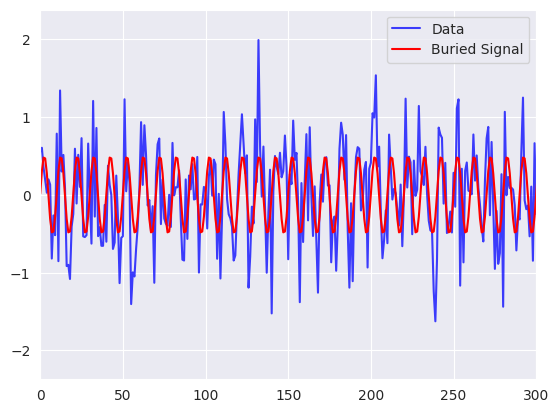

In [215]:
# Adaptive Line Enhancement
#Generate Data
f = 3
Fs = f*10
delay=10
N = 1024*2 + delay
noise  = np.random.normal(0,scale=0.5,size=N)
signal = 0.5*np.sin((2 * np.pi * f * np.arange(N) + np.pi/3)/ Fs)
data = signal + noise

#plt.plot(np.squeeze(data),label='Resonator Data')
plt.plot(data,label='Data',c='b',alpha=0.75)
plt.plot(signal,label='Buried Signal',c='r')
plt.legend()
plt.xlim([0,300])


S=N-delay
B=1
x_train=np.reshape(data[0:-delay],(B,S,1))
y_train=np.reshape(data[delay:],(B,S,1))
#x_train=np.reshape(data,(B,S,1))
#y_train=np.reshape(data,(B,S,1))

[0.02295589 0.21561374 0.26560548]


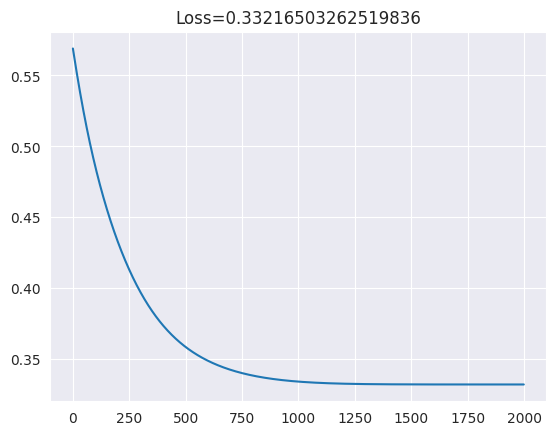

In [224]:
#Train
input = tf.keras.Input(shape=(S,1),name='input')
conv = tf.keras.layers.Conv1D(filters=1,kernel_size=3,activation=None,padding='causal',use_bias=False,name='Conv1')(input)
model = tf.keras.Model(inputs=input,outputs=conv)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss=tf.keras.losses.MeanSquaredError())
tf.keras.utils.plot_model(model, show_shapes=False)
history=model.fit(x_train, y_train,epochs=2000,shuffle=True,verbose=0)
plt.plot(history.history['loss'])
plt.title("Loss=%s"%history.history['loss'][-1])
a_hat=np.squeeze(model.layers[1].get_weights()[0])
print(a_hat)

(1858.0, 2058.0)

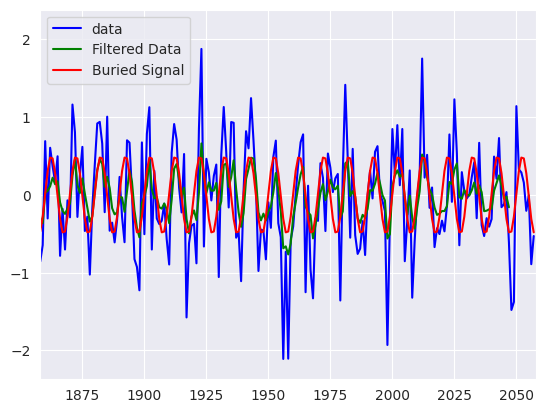

In [226]:
#Denoise and check results
out=model(x_train)
plt.plot(data,label='data',c='b')
plt.plot(np.squeeze(out),label='Filtered Data',c='g')
plt.plot(signal,label='Buried Signal',c='r')
plt.legend()
plt.xlim([N-200,N])

In [180]:
data

array([ 0.01692531,  0.77625812, -0.76743074, ...,  0.61396525,
        1.11476929,  0.53483543])